# Steps to build a pedigree and inject it in the simulation of the coalescence process of n genealogies

1. First install a couple of modules in case they are not installed in your computer or working environment:

In [138]:
!python3 -m pip install networkx
!python3 -m pip install pandas
!python3 -m pip install matplotlib
!python3 -m pip install msprime
!python3 -m pip install tskit

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade 

2. Import all required modules

In [1]:
import io
import tskit
import msprime
from IPython.display import SVG, display
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

3. Create 2 functions for building the pedigree and for visualizing it:
3.1 Function to create or parse the pedigree:
    Check that this function requires 3 parameters:
    a. N: Integer of the size of the population
    b. n: Integer of the size of the sample of interest at time zero.
    c. t: Integer of that indicates the time in the past we want to trace back all samples in the pedigree.
    d. big_family_size: number of offsprings a big family will have.

In [2]:

def build_random_pedigree(N, n, t, big_family_size):
    
    Pop_labels = range(N)
    Sample_labels = range(n)
    times = range(0, t)

    pedigree_table = pd.DataFrame()

    for time in times:
        # Select members of the big family
        time_t_sample_labels = [x + time * N for x in Pop_labels]
        time_t_parent_labels = [x + (time + 1) * N for x in Pop_labels]
        
        big_family_members_in_time_t = np.random.choice(time_t_sample_labels, big_family_size, replace=False)
        
        # Select members not in the big family
        if time == 0:
            other_inds_in_time_t = list(set(time_t_sample_labels) - set(big_family_members_in_time_t))
            other_inds_in_time_t = np.random.choice(other_inds_in_time_t, n - big_family_size, replace=False)
        else:
            other_inds_in_time_t = list(set(Sample_labels_for_next_t) - set(big_family_members_in_time_t))
        
        # Selecting the parents in time t
        parents_of_bigfamily_in_time_t = np.random.choice(time_t_parent_labels, 2, replace=False)
        
        big_family_pedigree_df = pd.DataFrame({
            'id': sorted(big_family_members_in_time_t),
            'parent0': [parents_of_bigfamily_in_time_t[0]] * big_family_size,
            'parent1': [parents_of_bigfamily_in_time_t[1]] * big_family_size,
            'time': [time] * big_family_size,
            'is_sample': [1 if time == 0 else 0] * big_family_size
        })
        
        other_parents_in_time_t = list(set(time_t_parent_labels) - set(parents_of_bigfamily_in_time_t))
        
        temp_pedigree_df = pd.DataFrame({
            'id': other_inds_in_time_t,
            'parent0': np.random.choice(other_parents_in_time_t, len(other_inds_in_time_t)),
            'parent1': np.random.choice(other_parents_in_time_t, len(other_inds_in_time_t)),
            'time': [time] * len(other_inds_in_time_t),
            'is_sample': [1 if time == 0 else 0] * len(other_inds_in_time_t)
        })
        
        pedigree_table = pd.concat([pedigree_table, big_family_pedigree_df, temp_pedigree_df])
        
        Sample_labels_for_next_t = list(set(
            big_family_pedigree_df['parent0'].tolist() +
            big_family_pedigree_df['parent1'].tolist() +
            temp_pedigree_df['parent0'].tolist() +
            temp_pedigree_df['parent1'].tolist()
        ))
        
        if time == times[-1]:
            last_generation = pd.DataFrame({
                'id': Sample_labels_for_next_t,
                'parent0': ['.' for _ in Sample_labels_for_next_t],
                'parent1': ['.' for _ in Sample_labels_for_next_t],
                'time': [time + 1 for _ in Sample_labels_for_next_t],
                'is_sample': [0 for _ in Sample_labels_for_next_t]
            })
            pedigree_table = pd.concat([pedigree_table, last_generation])

    pedigree_table = pedigree_table.sort_values('id').reset_index(drop=True)

    pedigree_table_string = "# id parent0 parent1 time is_sample\n"
    pedigree_table_string += pedigree_table.to_csv(sep='\t', index=False, header=False)
    
    return pedigree_table_string

3.2 Function to draw the pedigree:

In [3]:

def draw_pedigree(ped_ts):

    G = nx.DiGraph()
    for ind in ped_ts.individuals():
        time = ped_ts.node(ind.nodes[0]).time
        pop = ped_ts.node(ind.nodes[0]).population
        G.add_node(ind.id, time=time, population=pop)
        for p in ind.parents:
            if p != tskit.NULL:
                G.add_edge(ind.id, p)
    pos = nx.multipartite_layout(G, subset_key="time", align="horizontal")
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    node_colours = [colours[node_attr["population"]] for node_attr in G.nodes.values()]
    nx.draw_networkx(G, pos, with_labels=True, node_color=node_colours)
    plt.show()

Lets run an example on how to use this two functions:
a. First create the pedigree:
    For that we need to define the four inputs. To make a short demo let's define them as follow: 

In [4]:

N = 10
n = round(1 * N)
t = round(2 * np.log2(N))
big_family_size = 4


This mean that we are going to follow the full population of 10 individuals for 7 generations and in each generation 4 individuals are siblings from the same father and mother.
Other assumptions of the model are:
    * The population is diploid monoecious (so no sex is defined).
    * All samples in t_0 will have a value of 1 in the flag (column) is_sample, which mean they are going to be included in the simulation. For a future Implementation a parameter to randomly or manually define the samples to be included will be added.
    * Individuals that don't belong to the big family may share the same parents as a function of the size of the population. If N is big and n is small respect to N, this won't happen.
    * Individuals ar allowed to have multiple partners. If N is big and n is small respect to N, this won't happen or will be rare.
Notice that the output of this function is a table stored as a string and that can be visualized using print().


In [5]:
pedigree_string = build_random_pedigree(N = N, n = n, t = t, big_family_size=big_family_size)
print(pedigree_string)

# id parent0 parent1 time is_sample
0	10	17	0	1
1	13	15	0	1
2	18	16	0	1
3	13	15	0	1
4	14	16	0	1
5	10	16	0	1
6	14	19	0	1
7	17	19	0	1
8	13	15	0	1
9	13	15	0	1
10	27	20	1	0
11	24	28	1	0
13	24	28	1	0
14	24	28	1	0
15	20	21	1	0
16	24	28	1	0
17	27	23	1	0
18	21	25	1	0
19	20	23	1	0
20	31	37	2	0
21	32	34	2	0
23	30	39	2	0
24	38	36	2	0
25	33	32	2	0
27	31	37	2	0
28	31	37	2	0
29	31	37	2	0
30	47	42	3	0
31	40	41	3	0
32	49	46	3	0
33	41	42	3	0
34	45	41	3	0
36	49	46	3	0
37	49	46	3	0
38	49	46	3	0
39	44	47	3	0
40	51	54	4	0
41	59	50	4	0
42	57	56	4	0
44	57	56	4	0
45	55	59	4	0
46	58	59	4	0
47	50	55	4	0
48	57	56	4	0
49	57	56	4	0
50	60	64	5	0
51	62	65	5	0
52	68	67	5	0
53	68	67	5	0
54	68	67	5	0
55	62	61	5	0
56	66	62	5	0
57	61	65	5	0
58	68	67	5	0
59	69	66	5	0
60	77	78	6	0
61	76	73	6	0
62	75	76	6	0
63	77	78	6	0
64	74	70	6	0
65	77	78	6	0
66	77	78	6	0
67	74	75	6	0
68	73	70	6	0
69	73	75	6	0
70	.	.	7	0
73	.	.	7	0
74	.	.	7	0
75	.	.	7	0
76	.	.	7	0
77	.	.	7	0
78	.	.	7	0



b. Parse the pedigree into msprime:

In [6]:
pedigree_table = msprime.parse_pedigree(io.StringIO(pedigree_string), sequence_length=1000)


c. Draw the pedigree:

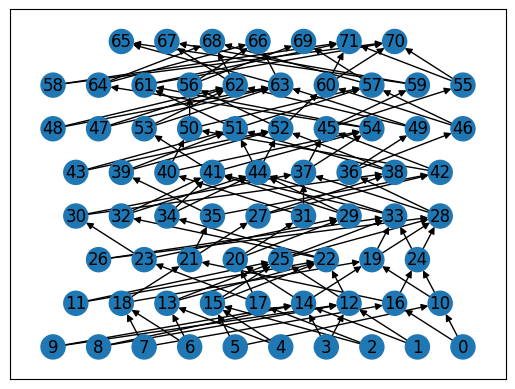

In [7]:
draw_pedigree(pedigree_table.tree_sequence())

d. Now we can use this pedigree to create our simulation:
   Notice that the .sim_ancestry method allows the following arguments:
    * samples: Any | None = None,*,
    * demography: Any | None = None,
    * sequence_length: Any | None = None,
    * discrete_genome: Any | None = None,
    * recombination_rate: Any | None = None,
    * gene_conversion_rate: Any | None = None,
    * gene_conversion_tract_length: Any | None = None,
    * population_size: Any | None = None,
    * ploidy: Any | None = None,
    * model: Any | None = None,
    * initial_state: Any | None = None,
    * start_time: Any | None = None,
    * end_time: Any | None = None,
    * record_migrations: Any | None = None,
    * record_full_arg: Any | None = None,
    * additional_nodes: Any | None = None,
    * coalescing_segments_only: Any | None = None,
    * num_labels: Any | None = None,
    * random_seed: Any | None = None,
    * num_replicates: Any | None = None,
    * replicate_index: Any | None = None,
    * record_provenance: Any | None = None

As the number of samples and the length of the sequence have been defined in the previous step, these two argument are already included in the argument initial_state

In [8]:
ts = msprime.sim_ancestry(
    initial_state=pedigree_table,
    model='fixed_pedigree',
    recombination_rate=0.0001,
    random_seed=45,
 #   additional_nodes=(
#         msprime.NodeType.RECOMBINANT |
#         msprime.NodeType.PASS_THROUGH | 
#         msprime.NodeType.COMMON_ANCESTOR
#         ),
    coalescing_segments_only=False
)

In [9]:
ts

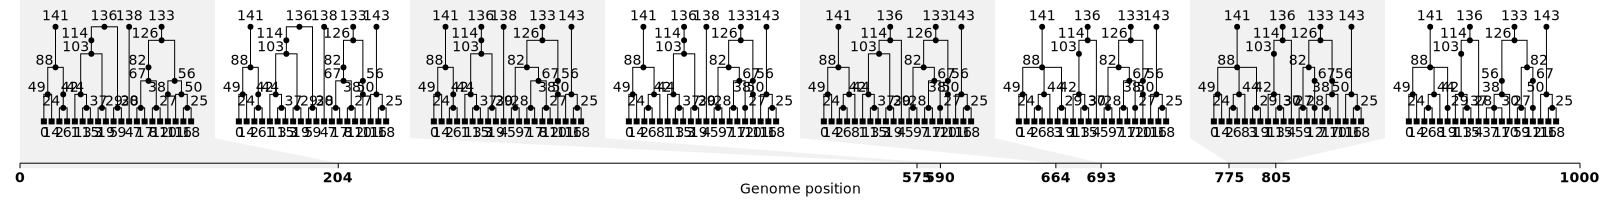

In [10]:
SVG(ts.draw_svg())

Let's try a bigger sample size

In [ ]:
N = 10000
n = round(0.1 * N)
t = round(2 * np.log2(N))
big_family_size = 20

pedigree_string = build_random_pedigree(N = N, n = n, t = t, big_family_size=big_family_size)
pedigree_table = msprime.parse_pedigree(io.StringIO(pedigree_string), sequence_length=1000)

ts = msprime.sim_ancestry(
    initial_state=pedigree_table,
    model='fixed_pedigree',
    recombination_rate=0.0001,
    random_seed=45,
 #   additional_nodes=(
#         msprime.NodeType.RECOMBINANT |
#         msprime.NodeType.PASS_THROUGH | 
#         msprime.NodeType.COMMON_ANCESTOR
#         ),
    coalescing_segments_only=False
)

In [12]:
ts